# Automatic Essay Scoring

## Data
Description: https://www.kaggle.com/c/asap-aes/data

The dataset contains essay and scores they received. There are three raters for two domains, but as we'll see, we will focus on only one rater. Moreover, there are "rater trait" variables which we can also discard, because we won't have such variables available on test sets.

The essay text had _entities_ removed and replaced with there generic name using an off-the-shelf [named entity recognition model](https://nlp.stanford.edu/software/CRF-NER.shtml). This includes seven entities: "PERSON", "ORGANIZATION", "LOCATION", "DATE", "TIME", "MONEY", and "PERCENT". For example, "Mike Smith ate dinner" --> "PERSON1 ate dinner." Note that the word was numbered too.

Additionally, six other entities were replaced:
1. "EMAIL" (anything that looks like an e-mail address)
2. "NUM" (word containing digits or non-alphanumeric symbols)
3. "CAPS" (any capitalized word that doesn't begin a sentence, except in essays where more than 20% of the characters are capitalized letters)
4. "DR" (any word following "Dr." with or without the period, with any capitalization, that doesn't fall into any of the above)
5. "CITY" (any city)
6. "STATE" (any state)

In [1]:
import numpy as np
import pandas as pd
%matplotlib inline

In [75]:
# Training set
train = pd.read_excel('asap-aes/training_set_rel3.xlsx')
train.shape

(12978, 28)

In [76]:
# View head
train.head()

,essay_id,essay_set,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
0,1,1,"Dear local newspaper, I think effects computer...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,1,"Dear @CAPS1 @CAPS2, I believe that using compu...",5.0,4.0,NaN,9.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,1,"Dear, @CAPS1 @CAPS2 @CAPS3 More and more peopl...",4.0,3.0,NaN,7.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,1,"Dear Local Newspaper, @CAPS1 I have found that...",5.0,5.0,NaN,10.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,1,"Dear @LOCATION1, I know having computers has a...",4.0,4.0,NaN,8.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Data Cleaning
The total dataset has 28 columns but many of them turn out to be useless for our purposes, so we will drop them. 
There are 8 essay prompts. Let's group by `essay_prompt` and count the values.

In [78]:
# essay_set
train.groupby('essay_set').count()

,essay_id,essay,rater1_domain1,rater2_domain1,rater3_domain1,domain1_score,rater1_domain2,rater2_domain2,domain2_score,rater1_trait1,...,rater2_trait3,rater2_trait4,rater2_trait5,rater2_trait6,rater3_trait1,rater3_trait2,rater3_trait3,rater3_trait4,rater3_trait5,rater3_trait6
essay_set,,,,,,,,,,,,,,,,,,,,,
1,1783,1783,1783,1783,0,1783,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1800,1800,1800,1800,0,1800,1800,1800,1800,0,...,0,0,0,0,0,0,0,0,0,0
3,1726,1726,1726,1726,0,1726,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1772,1772,1771,1771,0,1771,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,1805,1805,1805,1805,0,1805,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,1800,1800,1800,1800,0,1800,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,1569,1569,1569,1569,0,1569,0,0,0,1569,...,1569,1569,0,0,0,0,0,0,0,0
8,723,723,723,723,128,723,0,0,0,723,...,723,723,723,723,128,128,128,128,128,128


Note that:
1. There are three scorers for domain1, however, the _resolved score_, `domain1_score`, is our target variable. You can tell `domain1_score` is the target variable by seeing that its range is consistent with the sample submissions in `valid_sample_submission_5_column.csv`. Since the three scores are superfluous, and we won't have those variables in we drop them (`rater1_domain1`, `rater2_domain1`, `rater3_domain1`).
2. Each `essay_set` has its own prompt. The prompts can vary widely, so I focus on just one to start. I will look at only `essay_set==1`. Then, if the model is working, then I will generalize to all eight essay sets.
3. The _domain2_ scores apply to only `essay_id==2`, so I will drop them for now.
4. There are 6 trains for the three raters. I think these are characteristics of the person who is rating the essay. These personal characterestics should not be included because we cannot use them as predictive variables on test sets.

In [96]:
# Simplify data
train1 = train.loc[train.essay_set==1,:].drop(columns=['rater1_domain1', 'rater2_domain1', 'rater3_domain1']).iloc[:,0:4]

In [109]:
# descriptive statistics
train1.domain1_score.describe()

count    1783.000000
mean        8.528323
std         1.538565
min         2.000000
25%         8.000000
50%         8.000000
75%        10.000000
max        12.000000
Name: domain1_score, dtype: float64

The target variable ranges from 2 to 12, in discrete values.

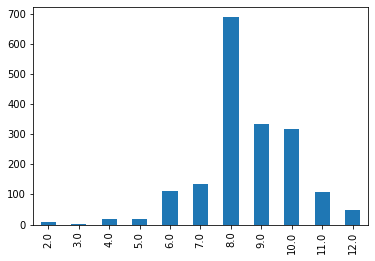

In [130]:
# frequency of target variable
train1.domain1_score.value_counts().sort_index().plot.bar();

Now that we simplified and cleaned the data, we turn to modeling.

# Spacy intro
https://spacy.io/usage/models#languages

In [2]:
import spacy

nlp = spacy.load("en_core_web_sm")
doc = nlp(u"Hello, world. Here are two sentences.")
print([t.text for t in doc])



['Hello', ',', 'world', '.', 'Here', 'are', 'two', 'sentences', '.']


In [3]:
nlp_de = spacy.load("de_core_news_sm")
doc_de = nlp_de(u"Ich bin ein Berliner.")
print([t.text for t in doc_de])

['Ich', 'bin', 'ein', 'Berliner', '.']


In [12]:
doc = nlp(u"Peach emoji is where it has always been. Peach is the superior "
          u"emoji. It's outranking eggplant 🍑 ")

In [13]:
noun_chunks = list(doc.noun_chunks)

In [22]:
sentences = list(doc.sents)

In [28]:
sentences[1].text

'Peach is the superior emoji.'

## scikit-learn

In [29]:
from sklearn.feature_extraction.text import CountVectorizer

In [30]:
vectorizer = CountVectorizer()

In [31]:
vectorizer

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words=None,
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [33]:
corpus = [
    'This is the first document.',
    'This is the second document.',
    'And the third one.',
    'Is this the first document?',
]
X = vectorizer.fit_transform(corpus)

In [34]:
X

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [35]:
analyze = vectorizer.build_analyzer()
analyze("This is a text document to analyze.") ==(['this', 'is', 'text', 'document', 'to', 'analyze'])

True

In [36]:
# columns
vectorizer.get_feature_names()

['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']

In [37]:
# each row is a document
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 1, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [39]:
# find column index
vectorizer.vocabulary_.get('document')

1

In [41]:
# 2-grams of words
# 
bigram_vectorizer = CountVectorizer(ngram_range=(1, 2),
                                     token_pattern=r'\b\w+\b', min_df=1)
analyze = bigram_vectorizer.build_analyzer()
analyze('Bi-grams are cool!')

['bi', 'grams', 'are', 'cool', 'bi grams', 'grams are', 'are cool']

In [42]:
X_2 = bigram_vectorizer.fit_transform(corpus).toarray()

In [43]:
X_2

array([[0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0],
       [0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0],
       [1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1]],
      dtype=int64)

In [44]:
feature_index = bigram_vectorizer.vocabulary_.get('is this')

In [46]:
X_2[:, feature_index]

array([0, 0, 0, 1], dtype=int64)

### Stop words
Words like 'the' and 'and'. Usually we remove stop words.

### Tf-idf
The idf term adds a 1 in the numerator and denominator, compared to the formulas given in Manning's book:

$$ idf(t) = \log \frac{1+n}{1+df(t)} + 1 $$

In [47]:
from sklearn.feature_extraction.text import TfidfTransformer
transformer = TfidfTransformer(smooth_idf=False)  # 1 added to idf, not to df in denom 
transformer

TfidfTransformer(norm='l2', smooth_idf=False, sublinear_tf=False, use_idf=True)

In [49]:
# example
counts = [[3, 0, 1],
          [2, 0, 0],
          [3, 0, 0],
          [4, 0, 0],
          [3, 2, 0],
          [3, 0, 2]]

tfidf = transformer.fit_transform(counts)
tfidf

<6x3 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

In [52]:
tfidf.toarray()

array([[0.81940995, 0.        , 0.57320793],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.47330339, 0.88089948, 0.        ],
       [0.58149261, 0.        , 0.81355169]])

In [53]:
transformer = TfidfTransformer()
transformer.fit_transform(counts).toarray()

array([[0.85151335, 0.        , 0.52433293],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.55422893, 0.83236428, 0.        ],
       [0.63035731, 0.        , 0.77630514]])

In [54]:
# idf of each term
transformer.idf_

array([1.        , 2.25276297, 1.84729786])

In [56]:
# combine CountVectorizer and TfidfTransformer into single model
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
vectorizer.fit_transform(corpus).toarray()

array([[0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674],
       [0.        , 0.40412895, 0.        , 0.40412895, 0.        ,
        0.63314609, 0.33040189, 0.        , 0.40412895],
       [0.55280532, 0.        , 0.        , 0.        , 0.55280532,
        0.        , 0.28847675, 0.55280532, 0.        ],
       [0.        , 0.43877674, 0.54197657, 0.43877674, 0.        ,
        0.        , 0.35872874, 0.        , 0.43877674]])

### Text features extraction 

In [69]:
#https://scikit-learn.org/stable/auto_examples/model_selection/grid_search_text_feature_extraction.html#sphx-glr-download-auto-examples-model-selection-grid-search-text-feature-extraction-py
import pandas as pd
from pprint import pprint
from time import time
import logging
import nltk
import re
from collections import defaultdict

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Define a pipeline combining a text feature extractor with a simple
# classifier
pipeline = Pipeline([
    ('vect', CountVectorizer()),
    ('tfidf', TfidfTransformer()),
    ('clf', SGDClassifier(tol=1e-3)),
])

# data
df = pd.read_excel('asap-aes/training_set_rel3.xlsx')
data = list(df[df.essay_set==1].essay)
target = df.domain1_score.values

In [155]:
class Ease_feature_extractor:
    def __init__(self):
        self.__feature_names = ['num_chars', 'num_words', 'num_commas', 'num_apostrophies', 'sent_end_punc', 'avg_sent_len', 'avg_word_len']
        self.__features = defaultdict()
        for name in self.__feature_names:
            self.__features[name] = []
        
    def fit_transform(self, raw_documents):
        assert type(raw_documents)==list
        for doc in raw_documents:
            
            # Length features
            self.__features['num_chars'].append(len(re.sub(r"\s+", "", doc)))
            self.__features['num_words'].append(len(nltk.RegexpTokenizer(r'\w+').tokenize(doc)))
            self.__features['num_commas'].append(len(nltk.RegexpTokenizer(r',').tokenize(doc)))
            self.__features['num_apostrophies'].append(len(nltk.RegexpTokenizer(r"'").tokenize(doc)))
            self.__features['sent_end_punc'].append(len(nltk.RegexpTokenizer(r'[.?!]').tokenize(doc)))
            
            sentence_lengths = [len(nltk.RegexpTokenizer(r'\w+').tokenize(sentence)) for sentence in nltk.sent_tokenize(doc)]
            self.__features['avg_sent_len'].append(sum(sentence_lengths)/len(sentence_lengths))
            
            words = [len(word) for word in nltk.RegexpTokenizer(r'\w+').tokenize(doc)]
            self.__features['avg_word_len'].append(sum(words)/len(words))
            
            # tf-idf
            vectorizer = TfidfVectorizer(sublinear_tf=True, use_idf=True)
            
            vectorizer = TfidfVectorizer(max_df=0.5, 
                                         max_features=opts.n_features,
                                         stop_words='english',
                                         use_idf=opts.use_idf)
            
            X = vectorizer.fit_transform(data)
            
            svd = TruncatedSVD(opts.n_components)
            #normalizer = Normalizer(copy=False)
            lsa = make_pipeline(svd, normalizer)

            X = lsa.fit_transform(X)
            
            return self.__features
            
            
    def get_feature_names(self):
        return self.__feature_names

    
fe_ex = Ease_feature_extractor()
X = fe_ex.fit_transform(data)
print(fe_ex.get_feature_names())        

['num_chars', 'num_words', 'num_commas', 'num_apostrophies', 'sent_end_punc', 'avg_sent_len', 'avg_word_len']


In [142]:
#fe_ex.features['num_chars']

In [145]:
l = ['a','b','c']
d=defaultdict()

In [147]:
d['a']=1
d.keys()

dict_keys(['a'])

In [15]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data).toarray()

In [21]:
X.shape

(1783, 15735)

In [105]:
# modeling
parameters = {
    'vect__max_df': (0.5, 0.75, 1.0),
    # 'vect__max_features': (None, 5000, 10000, 50000),
    'vect__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    # 'tfidf__use_idf': (True, False),
    # 'tfidf__norm': ('l1', 'l2'),
    'clf__max_iter': (20,),
    'clf__alpha': (0.00001, 0.000001),
    'clf__penalty': ('l2', 'elasticnet'),
    # 'clf__max_iter': (10, 50, 80),
}

grid_search = GridSearchCV(Pipeline,
                           parameters,
                           cv=5,
                           n_jobs=-1,
                           verbose=1)

print("Performing grid search...")
print("pipeline:", [name for name, _ in pipeline.steps])
print("parameters:")
pprint(parameters)
t0 = time()
grid_search.fit(data, target)
print("done in %0.3fs" % (time() - t0))
print()

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()
for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))


Performing grid search...
pipeline: ['vect', 'tfidf', 'clf']
parameters:
{'clf__alpha': (1e-05, 1e-06),
 'clf__max_iter': (20,),
 'clf__penalty': ('l2', 'elasticnet'),
 'vect__max_df': (0.5, 0.75, 1.0),
 'vect__ngram_range': ((1, 1), (1, 2))}


ValueError: Found input variables with inconsistent numbers of samples: [1783, 12978]